In [6]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

import torch
from torch import Tensor
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , utils , datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Step №1: **Preparing data**
Sources: [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge/data?select=train_masks.csv.zip)

In [21]:
mappings = pd.read_csv('train_masks.csv')
mappings

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
...,...,...
5083,fff9b3a5373f_12.jpg,386005 13 387915 27 389829 34 391744 38 393660...
5084,fff9b3a5373f_13.jpg,393674 6 395585 19 397498 26 399412 32 401327 ...
5085,fff9b3a5373f_14.jpg,401397 9 403309 19 405223 26 405389 145 407138...
5086,fff9b3a5373f_15.jpg,407257 6 407393 89 409171 12 409263 179 411086...


Let's look at the first image and its mask from the train dataset.

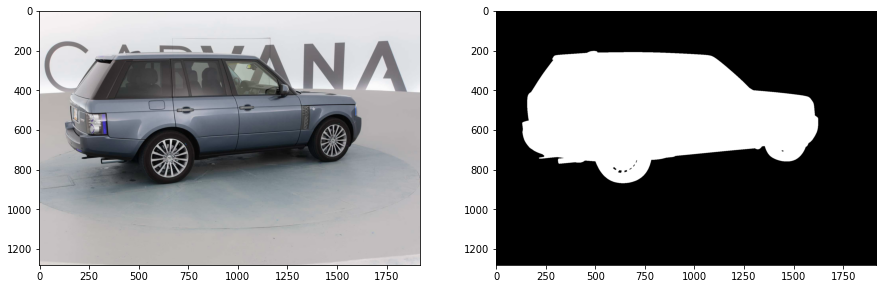

In [22]:
fig = plt.figure(figsize=(15, 15))
img = cv2.imread('./train/fff9b3a5373f_12.jpg')
mask = Image.open('./train_masks/fff9b3a5373f_12_mask.gif') 

files=[img, mask]
for i in range(len(files)):
    plt.subplot(1, 2 , i+1)
    plt.imshow(files[i])

Then let's create [PyTorch Dataset](https://pytorch.org/docs/stable/data.html) which contains all the objects used during the model's training. It reads all images with cars and its mask, then applies the mask to the image and executes edges detection algorithm to obtain a `sketch` version.

In [88]:
class DatasetWithMasks(Dataset) :
    def __init__(self, root_dir, img_list, get_edges):
        '''
            Parameters:
               - root_dir: path to the directory with `train` and `train_masks` folders.
               - img_list: an array with the names of the images.
               - get_edges: function that takes an image as an input and returns image on which
                            the edges have been detected (sketch).
        '''
        self.root_dir = root_dir
        self.image_list = img_list
        self.get_edges = get_edges
    
    def __len__(self) :
        return len(self.image_list)
    
    def __getitem__(self, idx) :
        
        img_name = self.image_list[idx]
        img_path = self.root_dir + '/' + str(img_name)
        
        mask_name = img_name.split('.')[0] + '_mask.gif'
        mask_path = self.root_dir + '_masks/' + str(mask_name)
        
        img = cv2.imread(img_path)
        mask = Image.open(mask_path)
        mask = np.array(mask)
        img[mask == 0] = 255
        edges = self.get_edges(img)
        
        return img, 255 - edges

In [92]:
carsDataset = DatasetWithMasks('./train', mappings['img'], lambda img: cv.Canny(img, 100, 200))

Then we are drawing the first 4 elements in put training dataset.

Image shape: (1280, 1918, 3). Sketch shape: (1280, 1918)
Image shape: (1280, 1918, 3). Sketch shape: (1280, 1918)
Image shape: (1280, 1918, 3). Sketch shape: (1280, 1918)
Image shape: (1280, 1918, 3). Sketch shape: (1280, 1918)


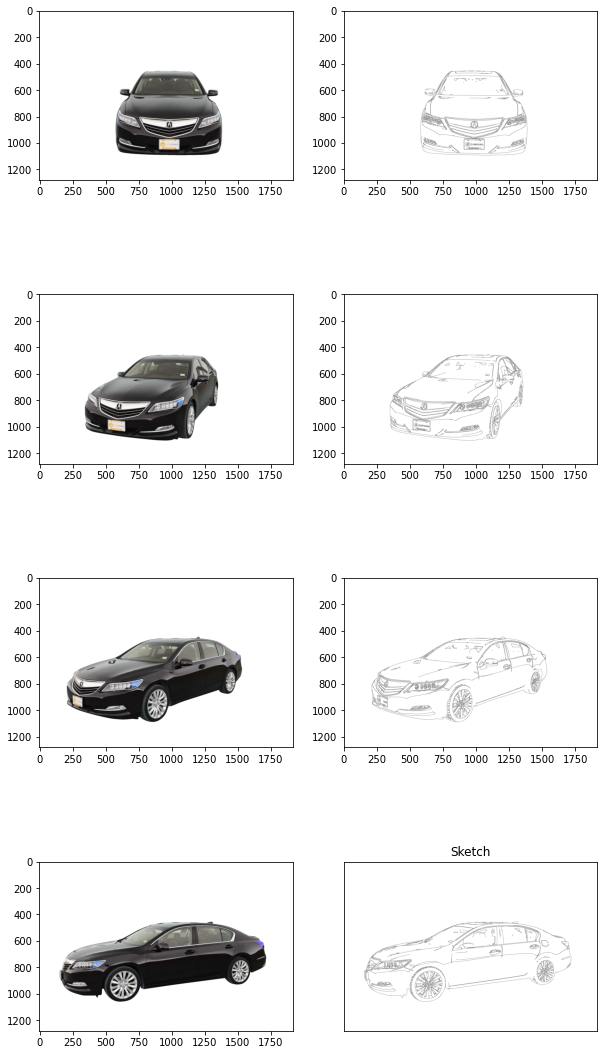

In [93]:
counter = 0
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
for img, sketch in carsDataset:
    if counter > 3:
        break
        
    print(f'Image shape: {img.shape}. Sketch shape: {sketch.shape}')
    ax[counter, 0].imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    ax[counter, 1].imshow(sketch, cmap='gray')
    plt.title('Sketch'), plt.xticks([]), plt.yticks([])
    counter += 1